# A.R.T. tutorial: improving production for an easy-to-learn function  

This notebook demostrates how to use the [Automated Recommendation Tool](https://www.nature.com/articles/s41467-020-18008-4) (A.R.T.) to guide a simulated bioengineering process, where the production is given by an 'easy' function.

Tested using **ART_v3.6 kernel** on [jprime.lbl.gov](https://jprime.lbl.gov/).

## Setup

The first step to run this notebook  is to make sure the `ART` library is installed.

If it is not, clone the corresponding git repository (or pull the latest version) to install it:

`git clone https://github.com/JBEI/AutomatedRecommendationTool.git`  
 
Information about licensing ART is available at https://github.com/JBEI/ART.



Next, we need to add the library to the path, and import its functions:


In [5]:
import sys
sys.path.append('../../AutomatedRecommendationTool/')       # Ensure this is the location for the ART library 
sys.path.append('.')                                                              # Add local directory to access some of the functions

import pandas as pd
from art.core import RecommendationEngine
import art.utility as utils
import numpy as np
import auxiliary_functions
import copy
import warnings

from IPython.display import Image                                                  # Used to display images

## Deciding the input and response

ART (and most of [machine learning](https://www.sciencedirect.com/science/article/pii/S109671762030166X)) works by learning the connection between a set of *inputs* (e.g. concentration for proteins in a pathway) and a corresponding *response* (e.g. production of biofuel). We will use a training set of known inputs and responses to derive a predictive model able to predict the response for new input, and then use that predictive models to find inputs that are predicted to improve our response:

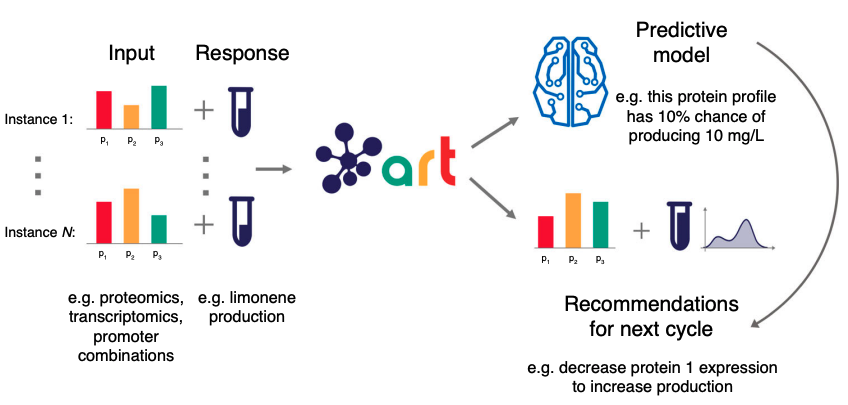

In [6]:
Image("ARToverview.png")

The predictions are probabilistic: i.e. instead of predicting that the protein concentrations p_1 = 0.5, p_2 = 0.2, p_3 = 0.7 will produce a production of 15 mg/L, the prediction is given in terms of a probability distribution. This probability distribution approach predicts that for p_1 = 0.5, p_2 = 0.2, p_3 = 0.7, there is e.g. a 10% chance of producing at most 10 mg/L, a 20% chance of producing at most 15 mg/L, ... etc. Hence this approach *quantifies uncertainty* for the prediction, which is a very useful characteristic when dealing with the small data sets characteristic of the field of synthetic biology.

For this tutorial, and for the sake of the example, our **input** will be composed of the concentrations for two proteins in the [mevalonate pathway](https://www.sciencedirect.com/science/article/pii/S109671761400161X?casa_token=CgEdQ91wK-sAAAAA:xWMpxuffL5Ukj7tyacW08VmwdR5jz1u8IjeXxJWb_FNMfn17yN_4XrVKgN2_Xql4Swjg8tIFf9bH) (e.g. atoB and HMGS) and the **response** will be isoprenol production. We will try to increase isoprenol production.

However, everything we do below will be usable for other pathway, final metabolite, number of proteins, transcripts or promoter combinations. This is a general procedure. 

## Defining the true response function

Rather than using experimental data for this tutorial, we will simulate it through an easy to learn function, of dimension 2 (the number of proteins in the input):

In [7]:
dimension = 2     # number of dimensions
lb, ub = 0., 10.  # lower and upper bounds for inputs (protein levels)

In [8]:
def true_function_easy(p, dimension):
    term1 = 0.
    term2 = 0.
    for i in range(dimension):
        term1 += (p[i] - 8)**2
        term2 += (p[i]-3)**2

    return 25-(1/dimension * term1 + np.exp(-term2))

This is a function that links the response $r$ (isoprenol production) to the concentration of proteins $p_1$ (atoB) and $p_2$ (HMGS) as follows:

$r = 25 - \left(\frac{1}{2}\left((p_1-8)^2+(p_2-8)^2\right) + e^{-\left((p_1-3)^2+(p_2-3)^2\right)}\right)$ 

and looks like this:

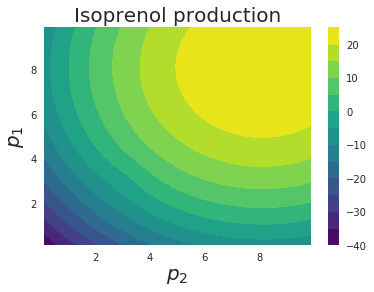

In [9]:
auxiliary_functions.plot_function(true_function_easy, [lb,ub], dimension) 

This functon is just a convenient example for this tutorial. We could have used a more realistic way to determine the relation between the isoprenol production (r) and the proteins ($p_1$,$p_2$) by using the [Omics Mock Generator](https://www.frontiersin.org/articles/10.3389/fbioe.2021.612893/full) (OMG) library, for example. However, for the purpose of this tutorial, this simplification suffices. The important point is that it does not matter whether the relation between response and input is given by synthetic data or real experimental data: the following steps are the same.

## ART input

### Defining the user parameters for running ART

It is useful to collect in a single dictionary all the parameters that we will use as inputs for ART to learn the function we defined above.

For example, the first parameter is the dimensionality of the input (in our case, we have two proteins, $p_1$ and $p_2$, so the dimensionality is 2: 

In [10]:
user_params = {'dim': dimension}

Then we need to tell ART which are the input ($p_1$ and $p_2$) and response ($r$) variables:

In [11]:
input_var = ['p_' + str(i) for i in range(1, user_params['dim'] + 1)]
response_var = ['r']

And then decide how many [instances](https://www.sciencedirect.com/science/article/pii/S109671762030166X#fig3) we will use for the initial DBTL cycle:

In [12]:
user_params['n_instances_cycle1'] = 7

We also need to define the number of [recommendations](https://www.nature.com/articles/s41467-020-18008-4/figures/1) for new inputs to be generated at each DBTL cycle:

In [13]:
user_params['num_recommendations'] = 5

as well as how many Design-Build-Test-Learn ([DBTL](https://www.frontiersin.org/files/Articles/160125/fbioe-03-00135-HTML/image_m/fbioe-03-00135-g001.jpg)) cycles we will do:

In [14]:
user_params['n_cycles'] = 4

We also need to tell ART what is our objective (in this case to maximize the response), and what we consider a success (in this case a 20% improvement over the best in the training data set, i.e., the threshold):

In [15]:
user_params['objective'] = 'maximize'
user_params['threshold'] = 0.2        

Also, ART needs an output directory for storing the results generated, and a random number generator seed to enable repeatability of the run (although the process is random, processes with the same seed produce the same results):

In [ ]:
import os
user_params['output_directory'] = './results/'
try:
    os.mkdir(user_params['output_directory'])
except FileExistsError:
    pass  # Ok if it has already been created.
user_params['seed'] = 30     

Finally, we need to define the exploitation-exploration parameter `alpha` ($\alpha$). This parameter determines whether we want create recommendations to *explore* the parts of the phase space where our model is less precise ($\alpha \sim 1$), or recommend new points that will *exploit* our model to obtain the highest production ($\alpha \sim 0$):

In [30]:
user_params['alpha_cycle2'] = 0.9
user_params['alpha_cycle3'] = 0.5
user_params['alpha_cycle4'] = None

You can find more details regarding $\alpha$ in equation 5 from the [ART paper](https://www.nature.com/articles/s41467-020-18008-4).

### Create file with bounds for input variables

Here we define the constraints on the input variables. For example, we limit ourselves only to positive values with an upper bound.

In [31]:
dim = user_params['dim'] 
bounds_file = user_params['output_directory']+'sim_data_bounds_FE.csv'


df = pd.DataFrame(columns=['Variable', 'Min', 'Max', 'Scaling'])
df['Variable'] = ['p_' + str(i) for i in range(1, dimension + 1)]
df['Min'] = lb*np.ones(dim)
df['Max'] = ub*np.ones(dim)
df['Scaling'] = np.ones(dim)
df = df.set_index('Variable')

print(df)
df.to_csv(path_or_buf=bounds_file)


          Min   Max  Scaling
Variable                    
p_1       0.0  10.0      1.0
p_2       0.0  10.0      1.0


## DBTL cycles 

We are now ready to start the Design-Build-Test-Learn cycles that will lead us to an increased production of isoprenol.

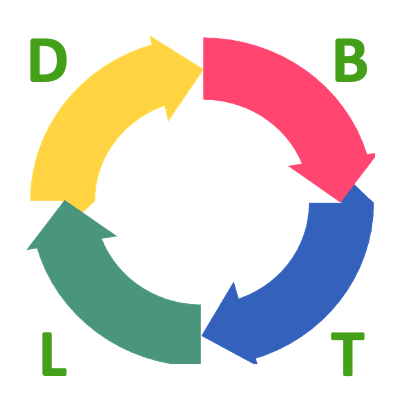

In [32]:
Image("DBTL.png")

### DBTL cycle 1

In [33]:
cycle = 1

#### Define input parameters

For the first cycle, we have no previously gathered information to make recommendations from, so we will create a set of recommended inputs such that they cover as much phase space as possible. This is achieved through the Latin Hypercube method ([McKay et al., 1979](https://amstat.tandfonline.com/doi/abs/10.1080/00401706.2000.10485979?casa_token=t3rYToRQxNUAAAAA%3AedYxZ4BsQrB2BDGIEw1ALAKNwgZIV-GOjEURzCT9rv1kdP_chO8DzEF4qS5P7_w89_SotCL_BbBsHnI&#.YAeui-lKii4)), which is included in ART and can be summoned setting input parameter `initial_cycle` to `True`. The rest of the parameters are explained above:

In [34]:
art_params = {
    'bounds_file': bounds_file,
    'input_vars': input_var,
    'response_vars': response_var,
    'num_recommendations': user_params['n_instances_cycle1'],    
    'initial_cycle': True,                                    # Set this to True for initial designs recommendations
    'seed': user_params['seed'],                              
    'output_directory': user_params['output_directory']  
}

#### Run ART

The next step is to run arts with the parameters we included in `art_params`:

In [35]:
art = RecommendationEngine(**art_params)

The recommendations can be found in the `art` structure:

In [36]:
art.recommendations

,p_1,p_2
0,7.337478,0.543926
1,2.375783,4.621511
2,6.550992,9.666936
3,4.232297,7.920195
4,0.920205,6.295272
5,5.702501,1.662358
6,9.311680,3.352374


In [37]:
x = [a for a in art.recommendations['p_1']]   
y = [a for a in art.recommendations['p_2']]

As you can see the values are chosen to be as separated from each other as possible:

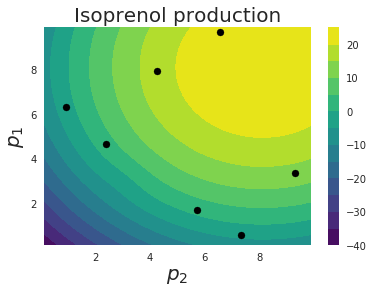

In [38]:
auxiliary_functions.plot_function(true_function_easy, [lb,ub], dimension, points=[x,y]) 

#### Save results as training data for next cycle

We now save this initial recommendations from the Latin Hypercube method in EDD-style files, to be used in the next cycle:

In [39]:
P = art.recommendations.values
r = true_function_easy(P.T, dim).reshape(-1, 1)
training_data_file = f'{art.outDir}sim_data_FE_cycle{str(cycle + 1)}.csv'     
utils.save_edd_csv(P, r, art.input_vars, training_data_file, response_vars_names=art.response_vars[0])

In [40]:
r_cycle1 = r
max(r_cycle1)[0]

22.56085004489315

### DBTL cycle 2

In [41]:
cycle += 1

#### Define input parameters

We change the parameters dictionary to reflect the new parameters for this cycle. The parameters include the objective, the threshold and the exploitation-exploration parameter $\alpha$:

In [42]:
art_params = {
    'bounds_file': bounds_file,
    'input_vars': input_var,               
    'response_vars': response_var,
    'objective': user_params['objective'],
    'threshold': user_params['threshold'],
    'alpha': user_params['alpha_cycle2'],
    'num_recommendations': user_params['num_recommendations'],  
    'seed': user_params['seed'],                           
    'output_directory': user_params['output_directory']  
}

Import training data file from previous DBTL cycle into a pandas dataframe:

In [43]:
df = utils.load_study(data_file=training_data_file)

#### Run ART

We know run ART to learn from those initial 7 instances, and the result are three graphs:

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


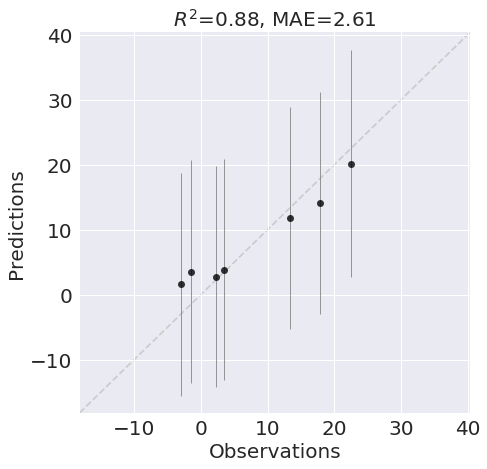

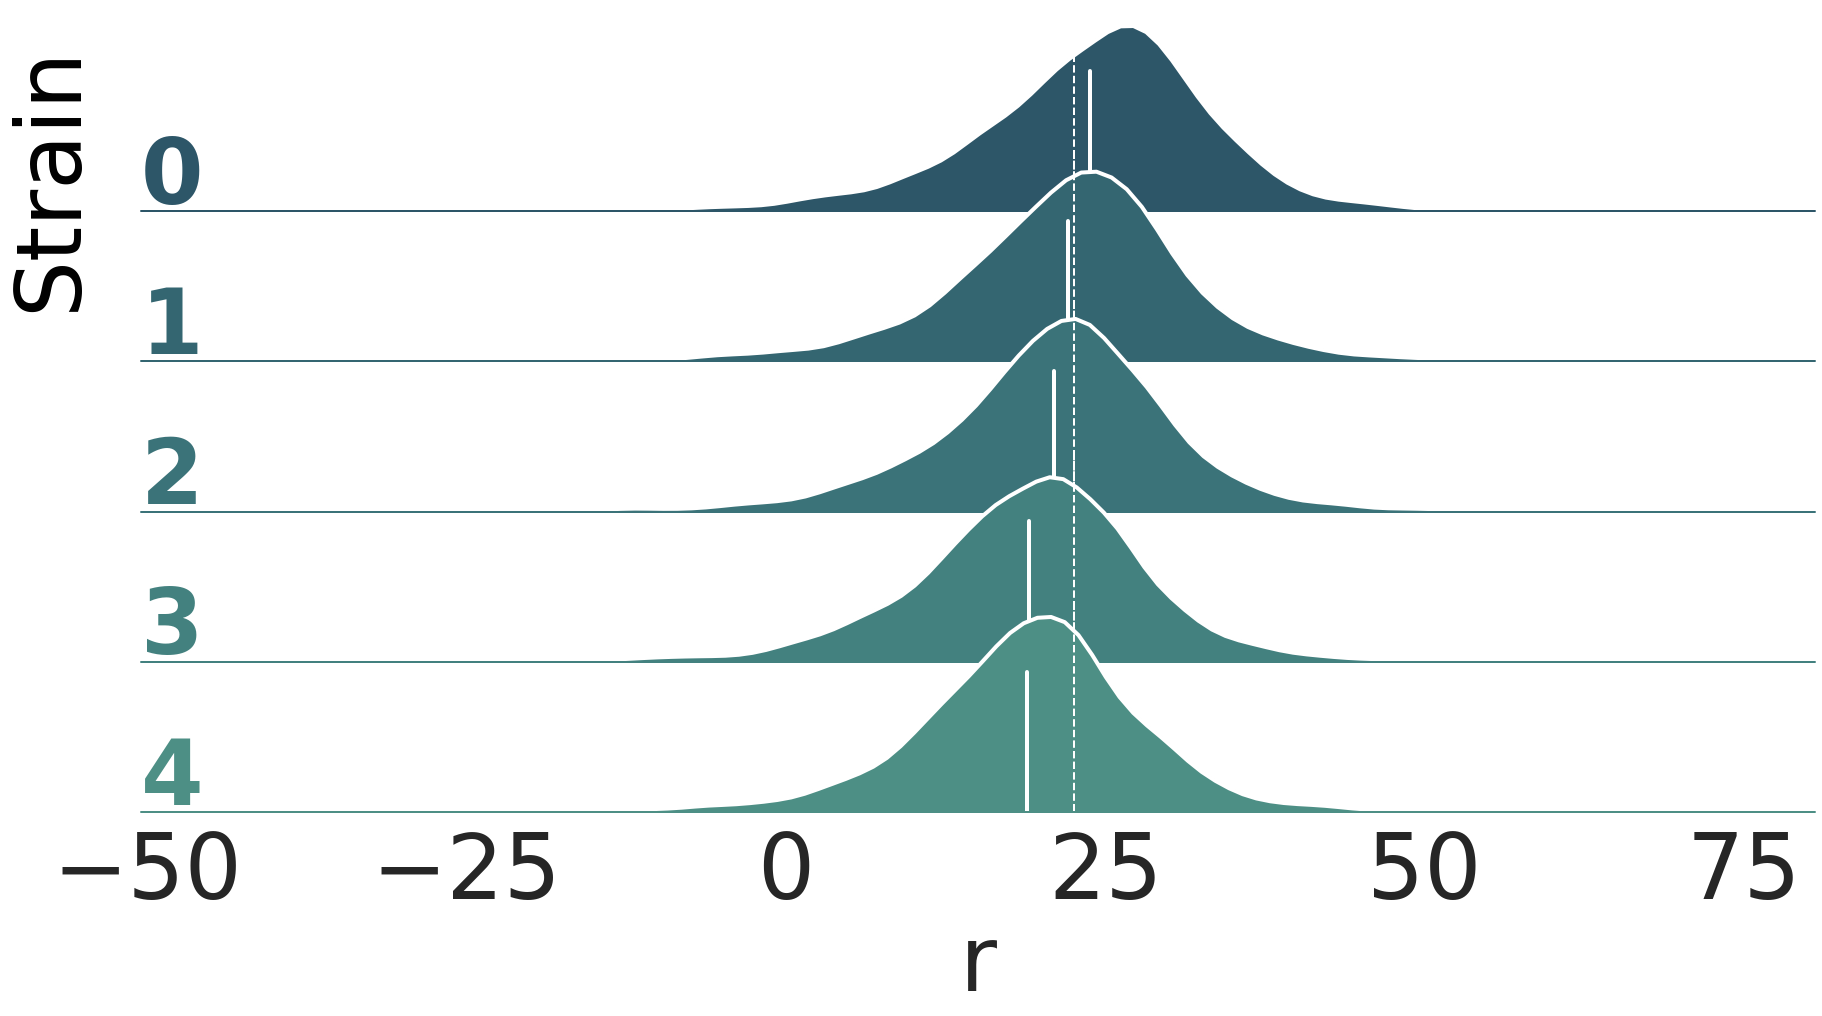

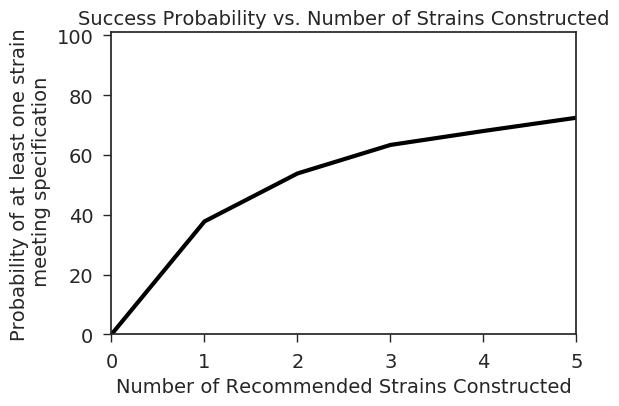

CPU times: user 7min 13s, sys: 26.6 s, total: 7min 40s
Wall time: 10min 28s


In [44]:
%%time
warnings.filterwarnings("ignore")
art = RecommendationEngine(df, **art_params)

The first graph involves a comparison between observed data and predictions. In this case, the predictions are good ($R^2 = 0.88$), despite ART not having too many instances to learn from. 

The second graph involves the probability distribution for the response (isoprenol production in this case) for each of the recommendations (5 in this case, as specified above under `num_recommendations`) provided by ART. The continous vertical line is the mean for each distribution, and the discontinous line is the best production level in the data set.

The third graph indicates the probability of achieving success as a function of strains tested. In this case, testing the 5 recommendations provided has \~70\% of achieving success 

This is the maximum response among the seven instances:

In [45]:
max(art.y)[0]

22.56085004489315

This the threshold for success (20% as discussed before):

In [46]:
art.threshold

0.2

And this is the production level that ART would consider a success for the purposes of the third graph:

In [47]:
max(art.y)[0] *(1+art.threshold)

27.07302005387178

#### Save training data for next cycle

We now simulate true values for the response variable for the ART recommendations using `true_function`, and save data in an EDD-style .csv file:

In [48]:
file_name = f'{art.outDir}sim_data_FE_cycle{str(cycle + 1)}.csv'
r_cycle2 = auxiliary_functions.simulate_recommendations_responses(art, true_function_easy, user_params['dim'], file_name)

The maximum value obtained by the recommendations is then:

In [49]:
max(r_cycle2)[0]

24.994487438428852

which is pretty much the maximum (25).

### DBTL cycle 3

In [50]:
cycle += 1

#### Define input parameters

Let's configure ART for the next cycle (no changes from previous cycle except new value of $\alpha$):

In [51]:
art_params['alpha'] = user_params['alpha_cycle3']

Import training data file into a pandas dataframe:

In [52]:
df = utils.load_study(data_file=f'{art.outDir}sim_data_FE_cycle{str(cycle)}.csv')

#### Run ART

Let's train ART with the response values associated with the recommended protein values obtained from cycle 1:

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
There were 158 divergences after tuning. Increase `target_accept` or reparameterize.
There were 230 divergences after tuning. Increase `target_accept` or reparameterize.


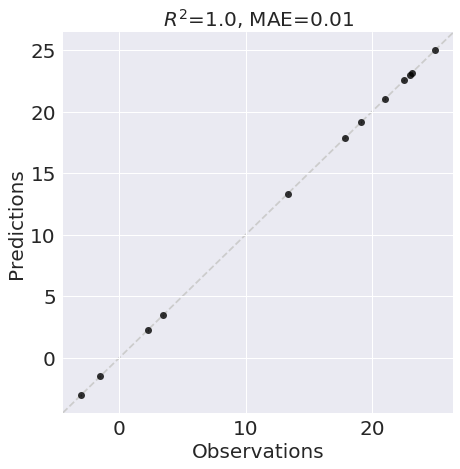

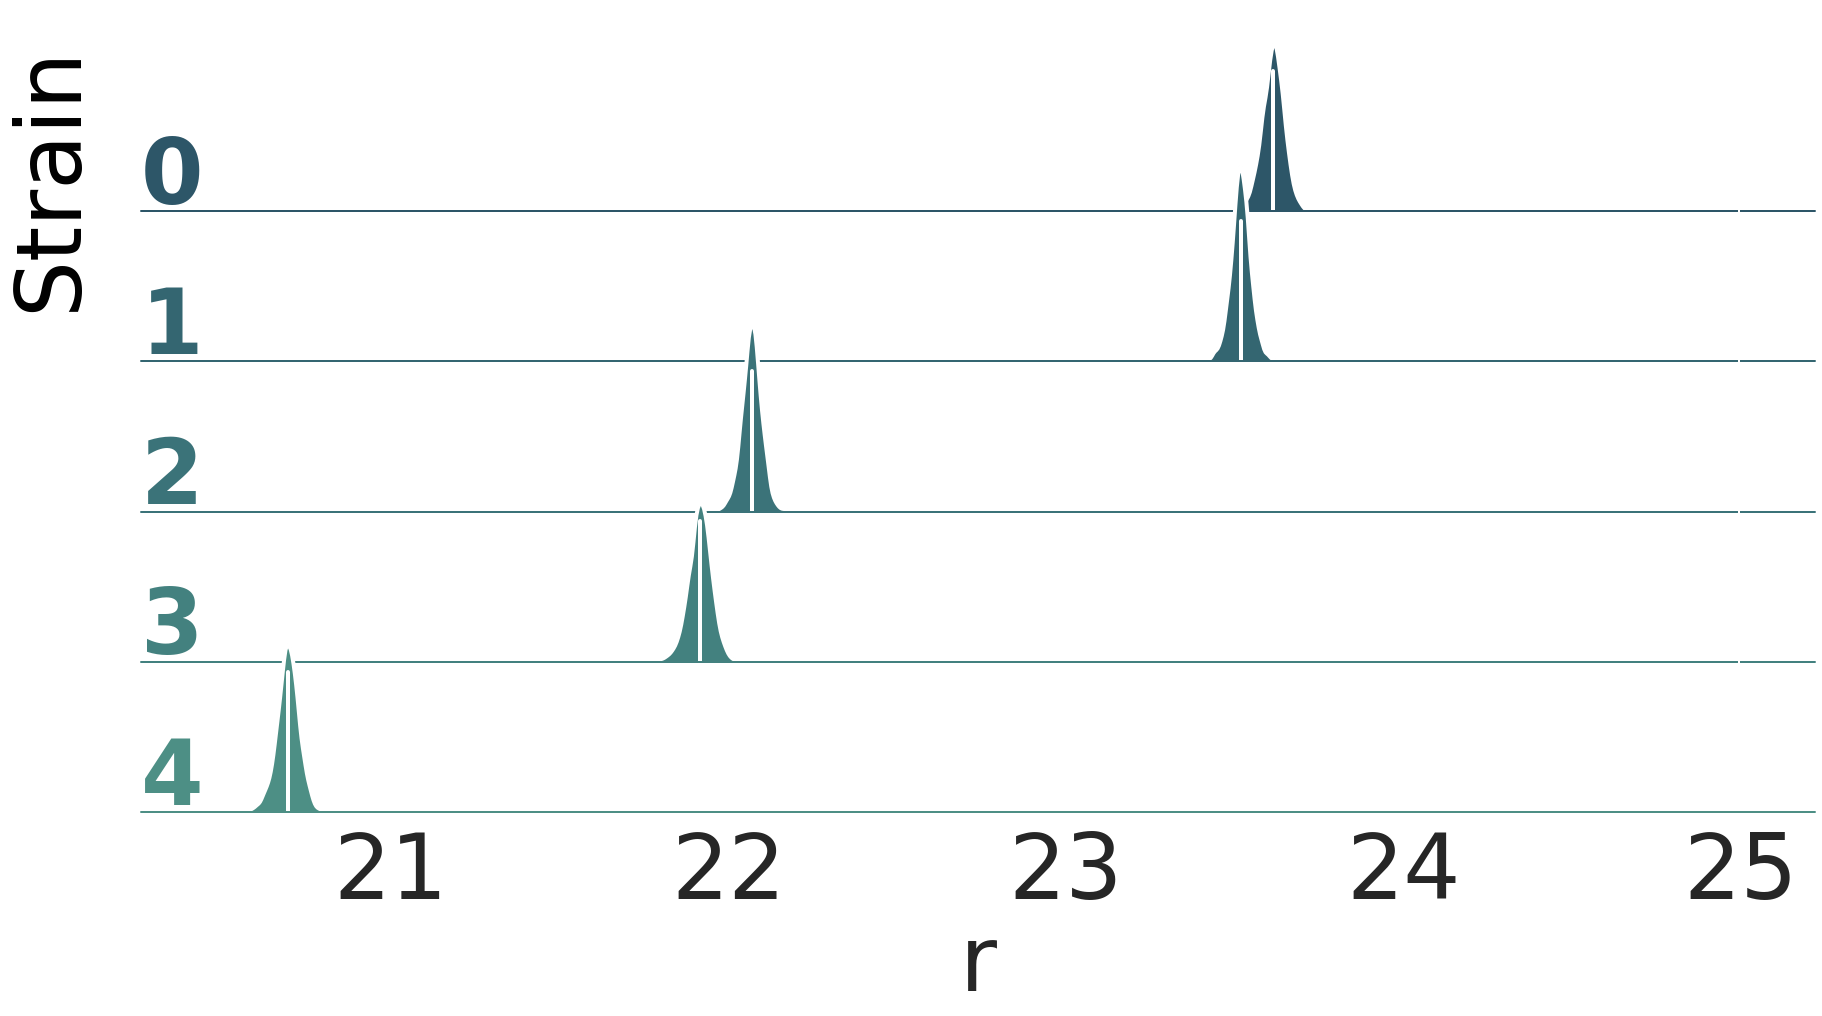

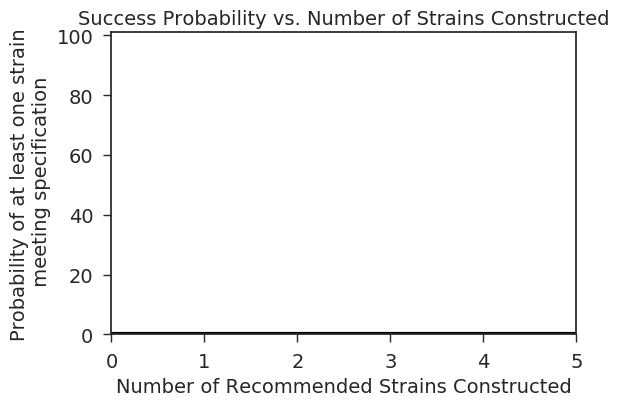

CPU times: user 24min 5s, sys: 3min 6s, total: 27min 12s
Wall time: 24min 37s


In [53]:
%%time
art = RecommendationEngine(df, **art_params)

In this third cycle (second with simulated experimental results), the predictions are perfect ($R^2 =1.0$), indicating that ART has learnt to predict the response for all training inputs. 
The new recommendations cannot really improve since the previous cycle recommendations already reached the limit:

In [54]:
max(art.y)[0]

24.994487438428852

And the probability that at least one strain exhibits production 20% over the maximum is zero since ART has now accuretaly learnt the production distribution, and the maximum is around 25.


## DBTL cycles for different starting instances

Let's see now what happens if we have different initial recommendations.

### DBTL Cycle 1

#### Define input parameters

First, let's create different sets of user parameters that differ only in the numbes of instances for cycle 1:

In [55]:
user_params_A  = copy.deepcopy(user_params) ; user_params_A['n_instances_cycle1'] = 7
user_params_B  = copy.deepcopy(user_params) ; user_params_B['n_instances_cycle1'] = 15
user_params_C  = copy.deepcopy(user_params) ; user_params_C['n_instances_cycle1'] = 30

In [56]:
art_params_A = {
    'bounds_file': bounds_file,
    'input_vars': input_var,
    'response_vars': response_var,
    'num_recommendations': user_params_A['n_instances_cycle1'],    
    'initial_cycle': True,                                    # Set this to True for initial designs recommendations
    'seed': user_params_A['seed'],                              
    'output_directory': user_params_A['output_directory']  
}

In [57]:
art_params_B = {
    'bounds_file': bounds_file,
    'input_vars': input_var,
    'response_vars': response_var,
    'num_recommendations': user_params_B['n_instances_cycle1'],    
    'initial_cycle': True,                                    # Set this to True for initial designs recommendations
    'seed': user_params_B['seed'],                              
    'output_directory': user_params_B['output_directory']  
}

In [58]:
art_params_C = {
    'bounds_file': bounds_file,
    'input_vars': input_var,
    'response_vars': response_var,
    'num_recommendations': user_params_C['n_instances_cycle1'],    
    'initial_cycle': True,                                    # Set this to True for initial designs recommendations
    'seed': user_params_C['seed'],                              
    'output_directory': user_params_C['output_directory']  
}

#### Run ART

And now we can run each of them separately:

In [59]:
art_A = RecommendationEngine(**art_params_A)
art_B = RecommendationEngine(**art_params_B)
art_C = RecommendationEngine(**art_params_C)

#### Save results as training data for next cycle

And here are the initial recommendations:

In [60]:
P_A = art_A.recommendations.values
r_A = true_function_easy(P_A.T, dim).reshape(-1, 1)
training_data_file_A = f'{art.outDir}sim_data_FE_cycle{str(cycle + 1)}_A.csv'     #Substitute file
utils.save_edd_csv(P_A, r_A, art_A.input_vars, training_data_file_A, response_vars_names=art_A.response_vars[0])

In [61]:
P_B = art_B.recommendations.values
r_B = true_function_easy(P_B.T, dim).reshape(-1, 1)
training_data_file_B = f'{art.outDir}sim_data_FE_cycle{str(cycle + 1)}_B.csv'     #Substitute file
utils.save_edd_csv(P_B, r_B, art_B.input_vars, training_data_file_B, response_vars_names=art_B.response_vars[0])

In [62]:
P_C = art_C.recommendations.values
r_C = true_function_easy(P_C.T, dim).reshape(-1, 1)
training_data_file_C = f'{art.outDir}sim_data_FE_cycle{str(cycle + 1)}_C.csv'     #Substitute file
utils.save_edd_csv(P_C, r_C, art_C.input_vars, training_data_file_C, response_vars_names=art_C.response_vars[0])

### DBTL Cycle 2

In [63]:
cycle += 1

#### Define input parameters

In [64]:
art_params = {
    'bounds_file': bounds_file,
    'input_vars': input_var,               
    'response_vars': response_var,
    'objective': user_params['objective'],
    'threshold': user_params['threshold'],
    'alpha': user_params['alpha_cycle2'],
    'num_recommendations': user_params['num_recommendations'],  
    'seed': user_params['seed'],                           
    'output_directory': user_params['output_directory']  
}

In [65]:
df_A = utils.load_study(data_file=training_data_file_A)
df_B = utils.load_study(data_file=training_data_file_B)
df_C = utils.load_study(data_file=training_data_file_C)

#### Run ART

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


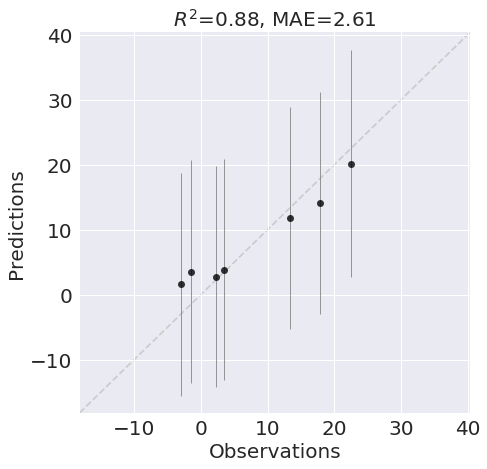

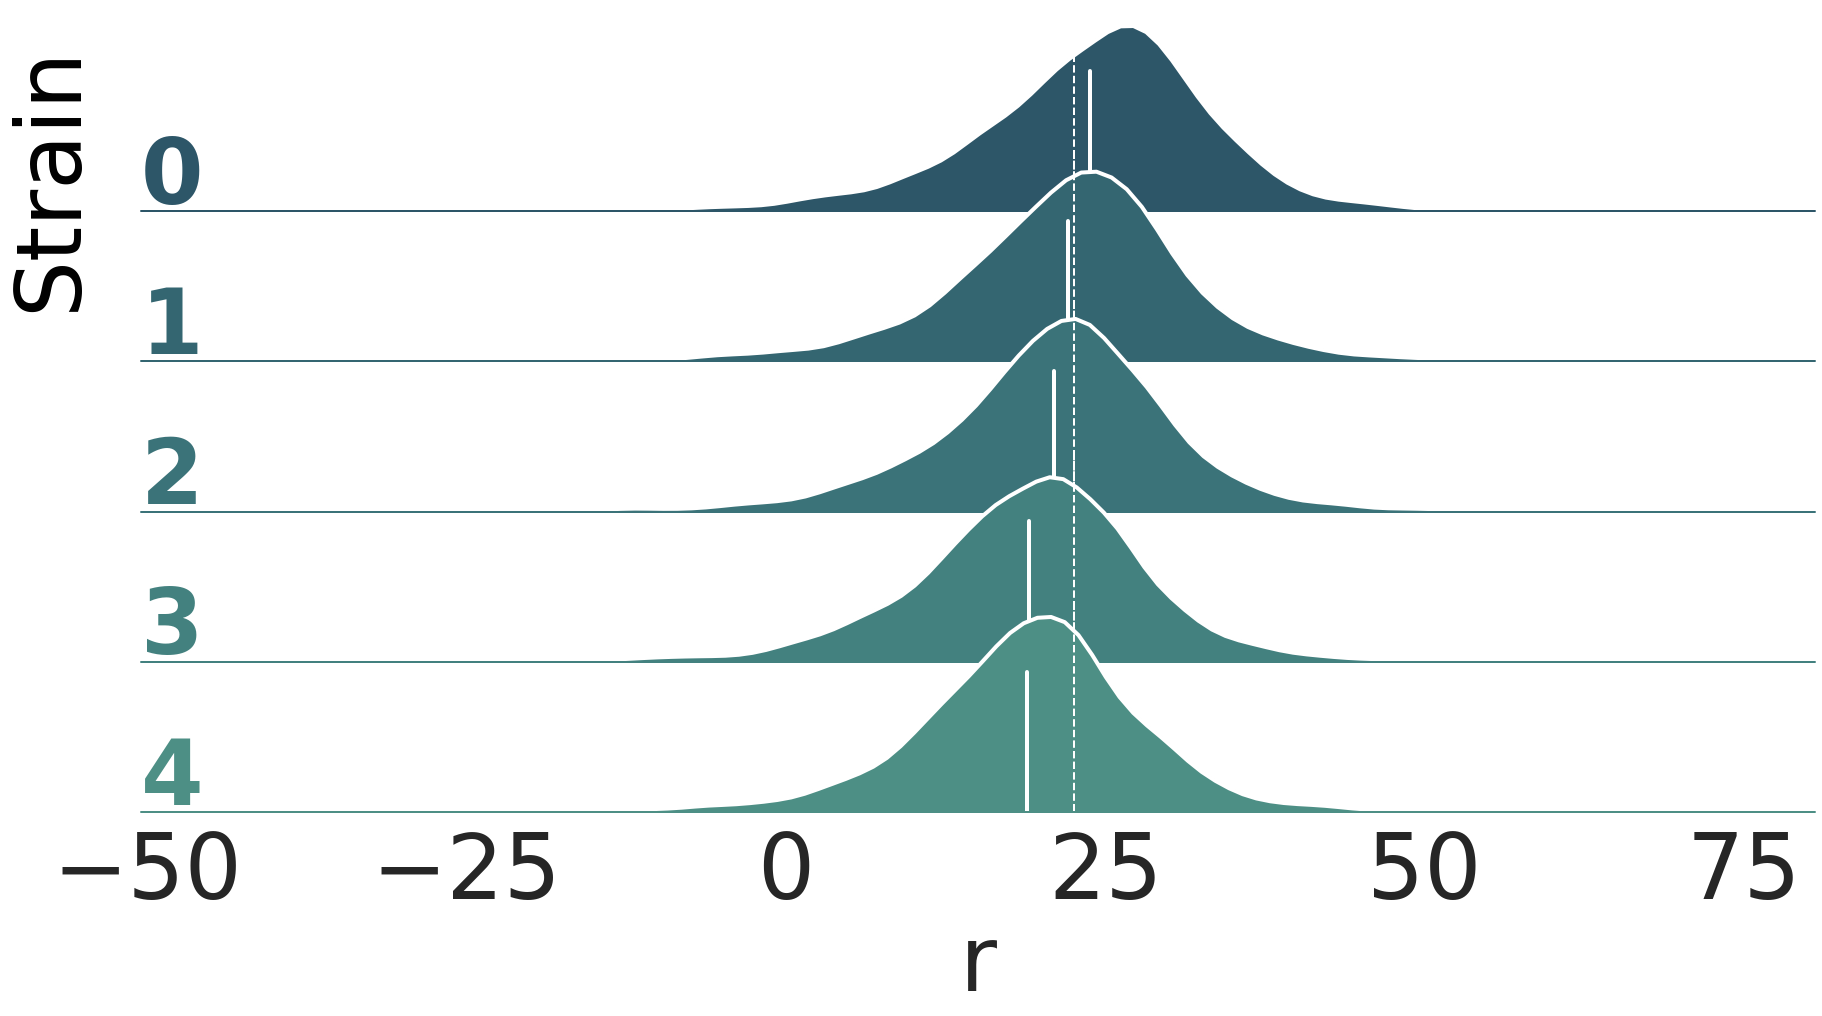

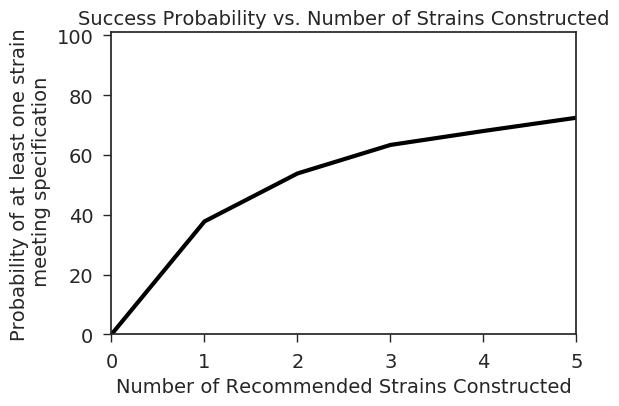

CPU times: user 7min 7s, sys: 22.2 s, total: 7min 29s
Wall time: 7min 45s


In [66]:
%%time
art_A = RecommendationEngine(df_A, **art_params)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
There were 182 divergences after tuning. Increase `target_accept` or reparameterize.
There were 42 divergences after tuning. Increase `target_accept` or reparameterize.


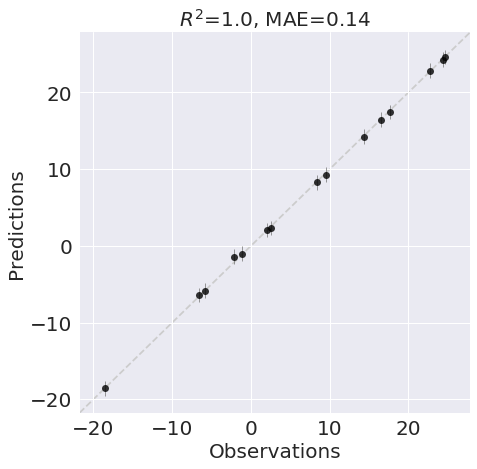

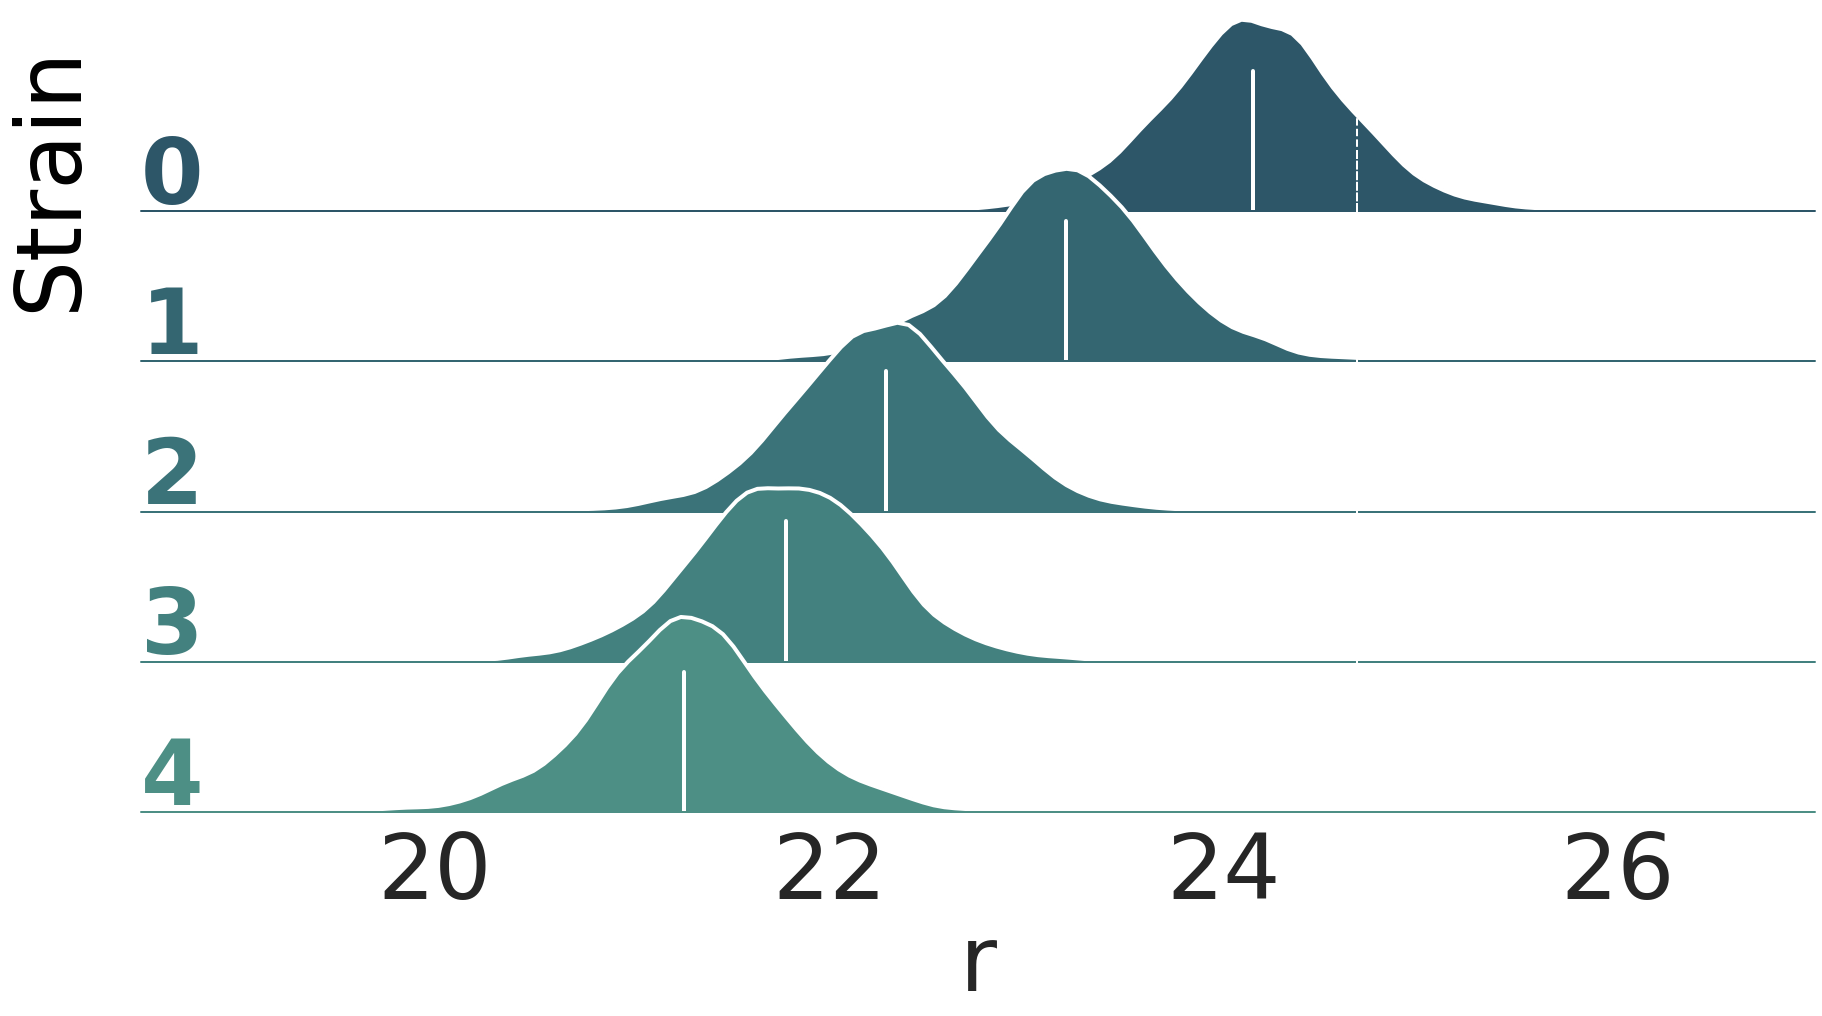

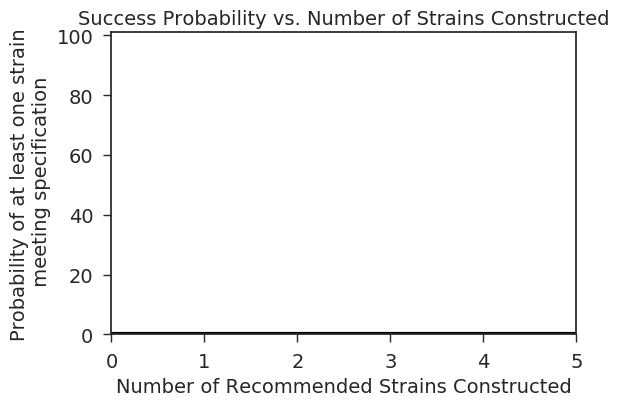

CPU times: user 10min 50s, sys: 3min 35s, total: 14min 25s
Wall time: 10min 47s


In [67]:
%%time
art_B = RecommendationEngine(df_B, **art_params)

Multiprocess sampling (2 chains in 2 jobs)
NUTS: [omegas, sigma]
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.


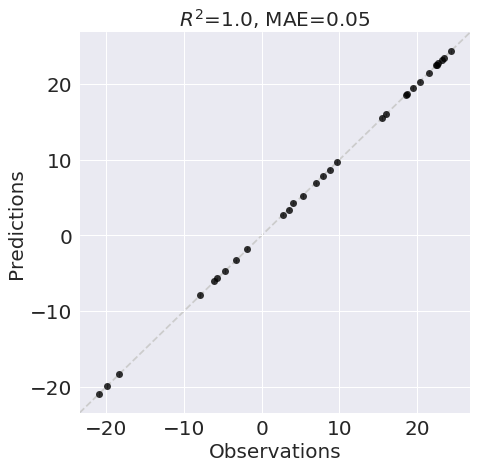

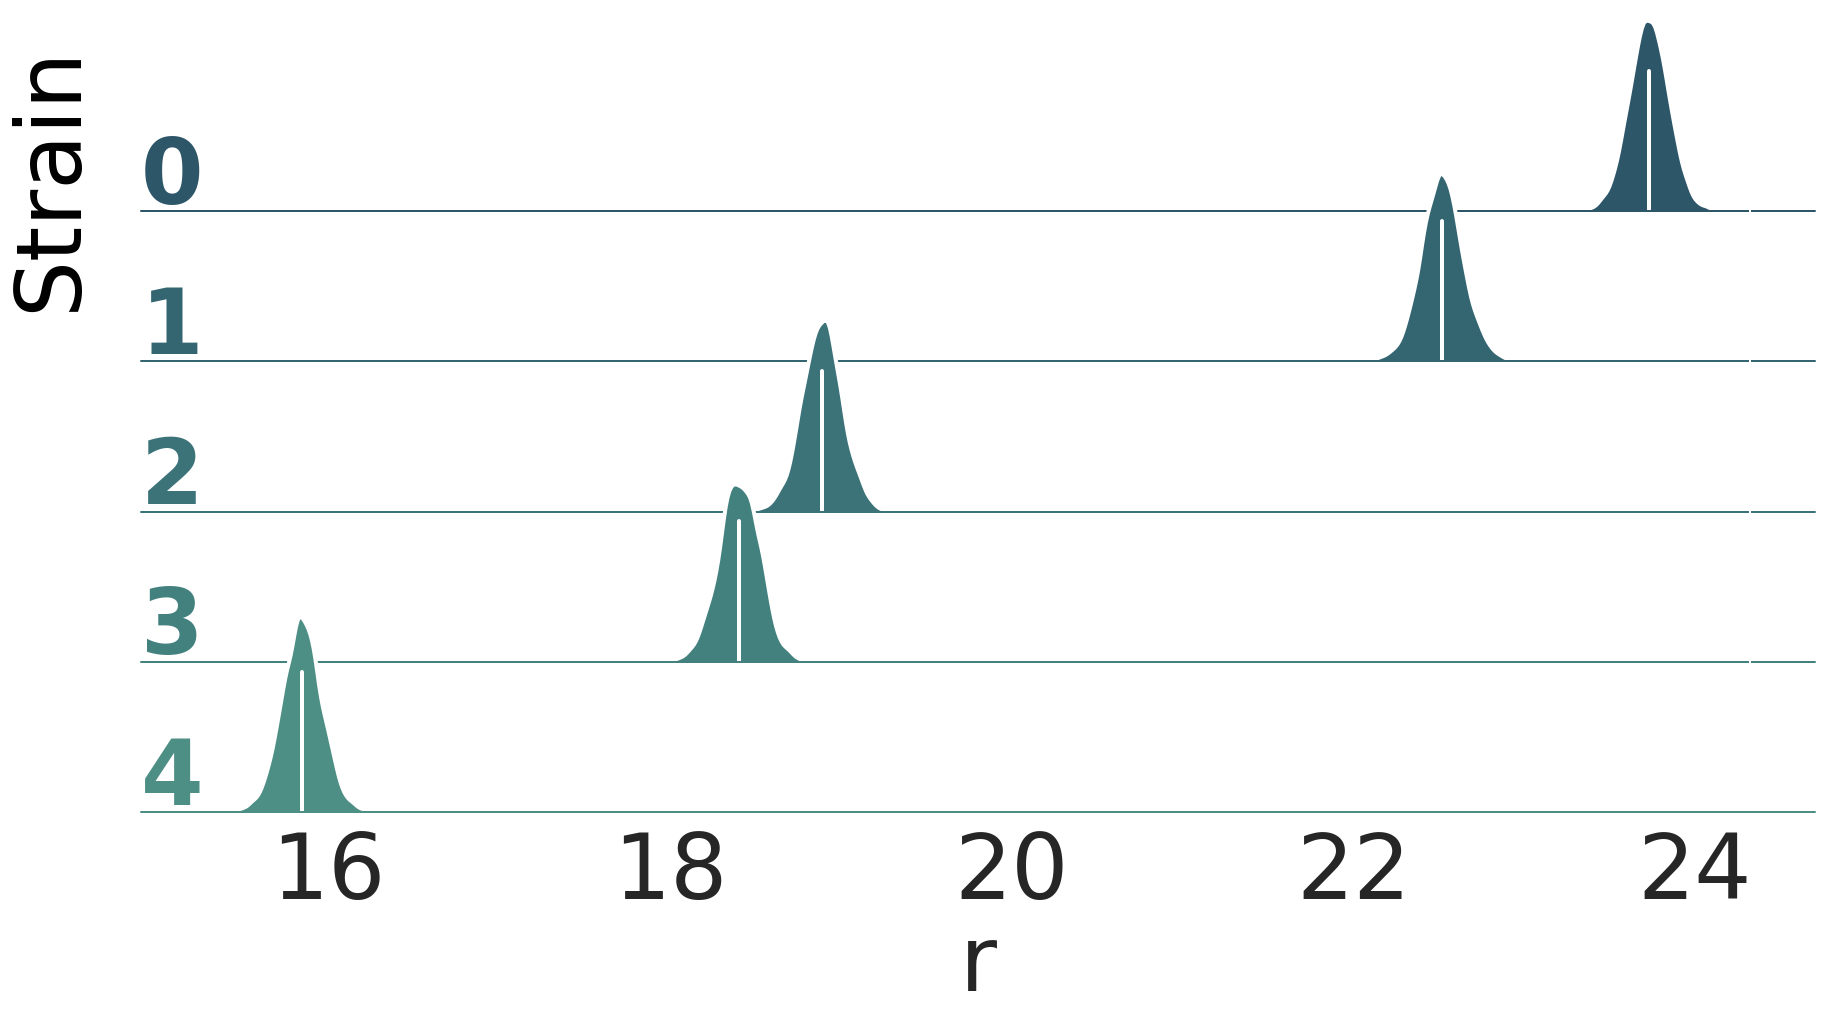

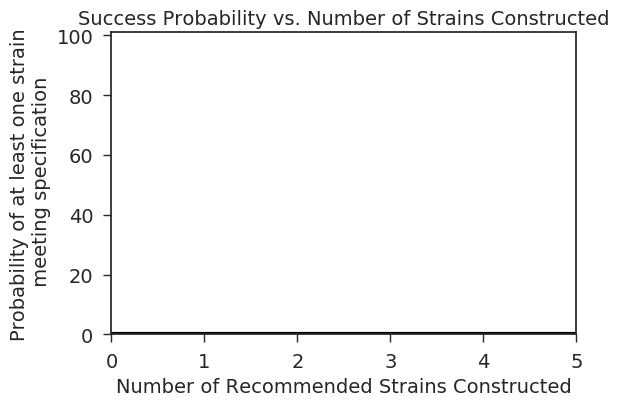

CPU times: user 22min 55s, sys: 8min 15s, total: 31min 10s
Wall time: 21min 44s


In [68]:
%%time
art_C = RecommendationEngine(df_C, **art_params)

As you can see the difference is significant: the larger the number of initial training instances the better the predictions. 